In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading datasets

In [ ]:
Po = np.load("Po.npz")
Pow= Po['data_array']
print(Pow.shape)

Li6 = np.load("Li6.npz")
Liw= Li6['data_array']
print(Liw.shape)

Phys = np.load("Phys.npz")
Physw= Phys['data_array']
print(Physw.shape)


(52238, 4, 7756)
(53000, 4, 7756)
(24000, 4, 7756)


# Exploration of the dataset and first approximation

## First approximation

For data exploration, it is insightful to examine the average across all signals and channels for each dataset. Notable differences can be observed in the pulse shapes (amplitudes and FWHM) between Li and Po. Furthermore, it is evident that the Phys dataset appears to be composed of a mix of Li and Po, as its pulse shape lies between those of the datasets composed exclusively of Po or Li (cf. figure on the left).
A first method to estimate the number of Li signals in the Phys dataset is to create a new dataset by combining the Li and Po datasets, introducing a known number of Li signals (and filling the rest with Po) until the resulting pulse shape resembles that of the Phys dataset. After several trials, we observe 'similar' pulses when the dataset is composed of 50% Li (cf. figure on right). Therefore, as an initial assumption, we can hypothesize that the Phys dataset consists of 50% Li and 50% Po.

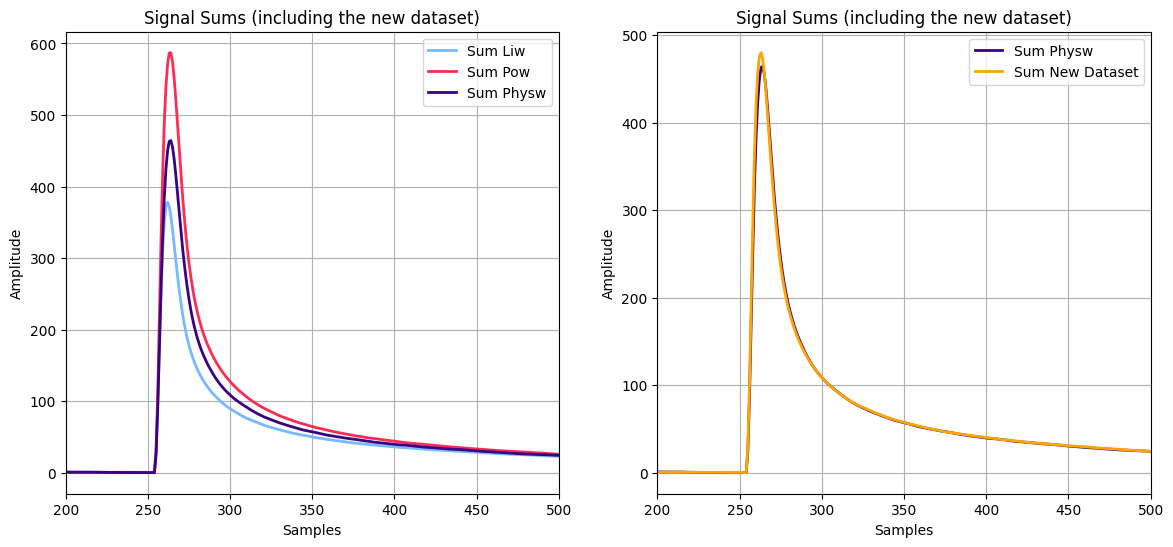

In [21]:
# Compute the sums of the 4 channels for each dataset
sum_Liw = np.mean(Liw, axis=(0, 1))  # Sum over all samples and channels
sum_Pow = np.mean(Pow, axis=(0, 1))
sum_Physw = np.mean(Physw, axis=(0, 1))


# Total size of the Physw dataset
total_samples = len(Physw)
nb_Li = total_samples // 2

# Build the new dataset
new_dataset = np.concatenate([Liw[len(Liw)//2: len(Liw)//2 + nb_Li], Pow[:(total_samples - nb_Li)]], axis=0)
sum_new_dataset = np.mean(new_dataset, axis=(0, 1))


# Display the sums on the same graph
plt.figure(figsize=(14, 6))

# Plot the sums
plt.subplot(1,2,1)
plt.plot(sum_Liw, color='#75bbfd', lw=2, label='Sum Liw')
plt.plot(sum_Pow, color='#fe2c54', lw=2, label='Sum Pow')
plt.plot(sum_Physw, color='#380282', lw=2, label='Sum Physw')

plt.title("Signal Sums (including the new dataset)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.xlim(200, 500)  # Sample limit on the X-axis
plt.legend()
plt.grid()


plt.subplot(1,2,2)
plt.plot(sum_Physw, color='#380282', lw=2, label='Sum Physw')
plt.plot(sum_new_dataset, color='#FFA500', lw=2, label='Sum New Dataset')

plt.title("Signal Sums (including the new dataset)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.xlim(200, 500)  # Sample limit on the X-axis
plt.legend()
plt.grid()

plt.show()


## Original AI-free discrimination method

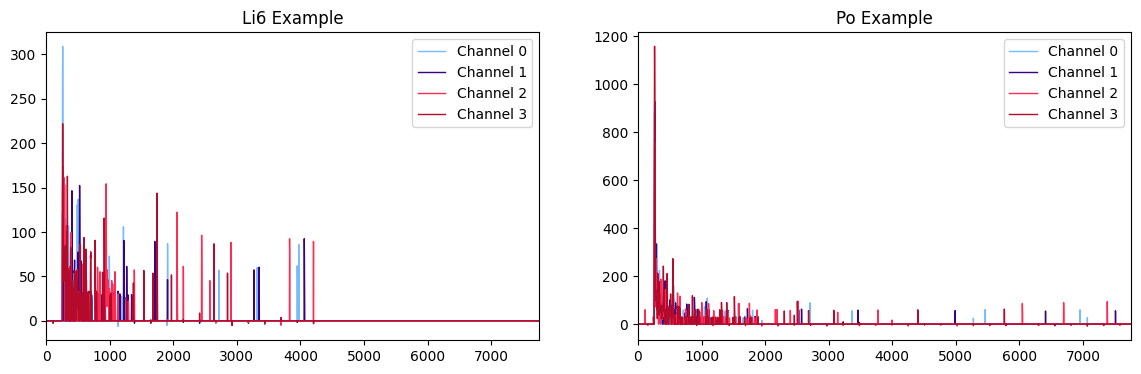

In [26]:
j = 1
i = 1

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(Liw[j][0], color='#75bbfd', lw=1, label='Channel 0')
plt.plot(Liw[j][1], color='#380282', lw=1, label='Channel 1')
plt.plot(Liw[j][2], color='#fe2c54', lw=1, label='Channel 2')
plt.plot(Liw[j][3], color='#b40b2c', lw=1, label='Channel 3')
plt.title("Li6 Example")
plt.xlim(0, 7756)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Pow[i][0], color='#75bbfd', lw=1, label='Channel 0')
plt.plot(Pow[i][1], color='#380282', lw=1, label='Channel 1')
plt.plot(Pow[i][2], color='#fe2c54', lw=1, label='Channel 2')
plt.plot(Pow[i][3], color='#b40b2c', lw=1, label='Channel 3')
plt.title("Po Example")
plt.xlim(0, 7756)
plt.legend()

plt.show()


After plotting multiple samples from each dataset, we noticed an interesting detail: although averaging all signals from each dataset results in a mean intensity of zero, individual signal plots reveal a different story. Specifically, the probability of observing a non-zero value after a certain time (6000) is markedly different for Li6 and Po. At first glance, it appears that signals associated with Po have a high likelihood of exhibiting residual energy peaks after this time, whereas such occurrences seem much rarer for Li6.

After several trials, here is the discrimination criterion we decided to use:
For an event, if at least two of the four acquisition channels measure a non-zero value after index 6000, it is classified as a Po. This leads to very encouraging results !

Percentage of valid Po signals: 99.31%
Percentage of invalid Po signals: 0.69%
Percentage of valid Li signals: 97.75%
Percentage of invalid Li signals: 2.25%


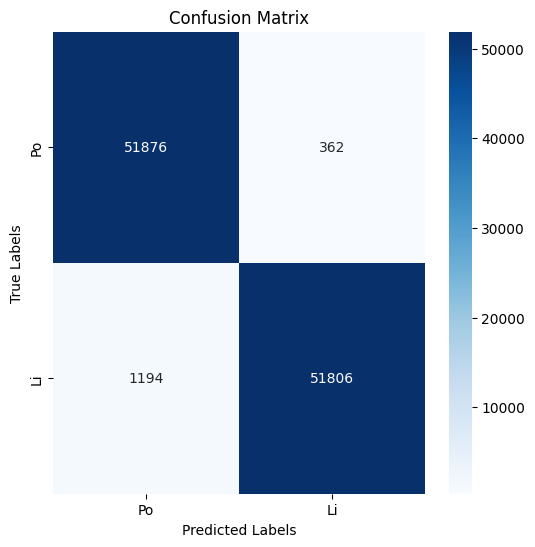

In [27]:
# Initialization of counters for Po and Li
count_Po = 0
count_Li = 0
threshold = 6000  # Define the threshold


for signal in Pow:
    # Count the number of channels with non-zero values after the threshold
    valid_channels = sum([np.any(signal[channel][threshold:] != 0) for channel in range(4)])
    if valid_channels >= 2:
        count_Po += 1

for signal in Liw:
    valid_channels = sum([np.any(signal[channel][threshold:] != 0) for channel in range(4)])
    if valid_channels >= 2:
        count_Li += 1

# Total of Po and Li events
nb_Po = Pow.shape[0]
nb_Li = Liw.shape[0]

# Calculate percentages of valid and invalid signals
nb_Po_OK = count_Po / nb_Po
nb_Po_notOK = 1 - nb_Po_OK
nb_Li_notOK = count_Li / nb_Li
nb_Li_OK = 1 - nb_Li_notOK

print(f"Percentage of valid Po signals: {nb_Po_OK * 100:.2f}%")
print(f"Percentage of invalid Po signals: {nb_Po_notOK * 100:.2f}%")
print(f"Percentage of valid Li signals: {nb_Li_OK * 100:.2f}%")
print(f"Percentage of invalid Li signals: {nb_Li_notOK * 100:.2f}%")


# Create the confusion matrix
conf_mat = np.array([[count_Po, nb_Po - count_Po], 
                     [count_Li, nb_Li- count_Li]])
conf_mat = conf_mat.astype(int)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Po', 'Li'], yticklabels=['Po', 'Li'])
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()


print()

# For threshold choice 

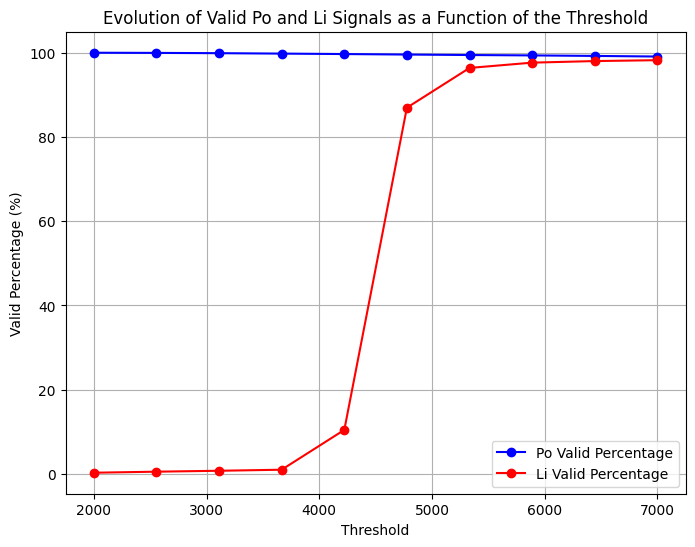

In [30]:
# Initialization of counters for Po and Li
thresholds = np.linspace(2000, 7000, 10, dtype=int)  # Thresholds ranging from 4000 to 7000 with 10 points
Po_percentages = []
Li_percentages = []

# Iterate over different thresholds
for threshold in thresholds:
    count_Po = 0
    count_Li = 0
    
    # Count valid signals for Po
    for signal in Pow:
        valid_channels = sum([np.any(signal[channel][threshold:] != 0) for channel in range(4)])
        if valid_channels >= 2:
            count_Po += 1

    # Count valid signals for Li
    for signal in Liw:
        valid_channels = sum([np.any(signal[channel][threshold:] != 0) for channel in range(4)])
        if valid_channels >= 2:
            count_Li += 1

    # Total of Po and Li events
    nb_Po = Pow.shape[0]
    nb_Li = Liw.shape[0]

    # Calculate percentages of valid signals for this threshold
    nb_Po_OK = count_Po / nb_Po
    nb_Li_notOK = count_Li / nb_Li
    nb_Li_OK = 1 - nb_Li_notOK


    # Store the percentages
    Po_percentages.append(nb_Po_OK * 100)
    Li_percentages.append(nb_Li_OK * 100)


# Plotting the evolution of percentages
plt.figure(figsize=(8, 6))
plt.plot(thresholds, Po_percentages, label='Po Valid Percentage', marker='o', color='b')
plt.plot(thresholds, Li_percentages, label='Li Valid Percentage', marker='o', color='r')
plt.title("Evolution of Valid Po and Li Signals as a Function of the Threshold")
plt.xlabel("Threshold")
plt.ylabel("Valid Percentage (%)")
plt.legend()
plt.grid(True)
plt.show()


# Test on Phys dataset

In [29]:
count_Phys = 0
# Iterate over the Phys signals
for signal in Physw:
    # Count the number of channels with non-zero values after the threshold
    valid_channels = sum([np.any(signal[channel][threshold:] != 0) for channel in range(4)])
    # Increment the counter if at least 2 channels meet the criterion
    if valid_channels >= 2:
        count_Phys += 1
        
        
for signal in Liw:
    valid_channels = sum([np.any(signal[channel][threshold:] != 0) for channel in range(4)])
    if valid_channels >= 2:
        count_Li += 1


print(f"Number of Po in Phys: {count_Phys}")
print(f"Number of Li in Phys: {Physw.shape[0] - count_Phys}")


Number of Po in Phys: 23827
Number of Li in Phys: 173


As seen above, the results obtained using this method are extremely unusual compared to what we expected based on previous findings. Indeed, only 173 Li events seem to be identified, which is surprisingly low, especially after performing some tests with CNNs. These results are quite strange, given that the previous confusion matrix showed very promising outcomes with an accuracy exceeding 98% for both Li and Po. A possible explanation could be that the detector used for acquiring the Phys signals is different from the ones used for acquiring the other datasets.